In [3]:
# Imports
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from diffusers import AutoPipelineForText2Image
from deep_translator import GoogleTranslator
import re
import cv2
import numpy as np
import ezdxf

# device to be used
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cpu


In [4]:
def hebrew_translator(user_prompt):
    """
    function for testing whether user's input is in Hebrew or in English - if it's
    in Hebrew then it will translate it to English
    :param user_prompt:
    :return:
    """
    contains_hebrew = re.search(r"[\u0590-\u05FF]", user_prompt) is not None
    if contains_hebrew:
        return GoogleTranslator(source='auto', target='en').translate(user_prompt)
    else:
        prompt_en = user_prompt

    return prompt_en

In [46]:
def add_nikud(text):
    """
    מוסיפה סימנים לוגיים (יוניקוד) לפי בחירת המשתמש:
    ב כ פ – דגש
    ו – חולם / שורוק / רגיל
    י – עם חיריק / בלי
    ש – s או sh
    """

    result = ""

    for ch in text:

        # ב כ פ – דגש
        if ch in ('ב', 'כ', 'פ'):
            ans = input(f"האם האות '{ch}' היא עם דגש? (כן/לא) ").strip().lower()
            result += ch
            if ans == 'כן':
                result += DAGESH

        # ו – חולם / שורוק / רגיל
        elif ch == 'ו':
            ans = input(
                "האם זו ו עם חולם vo / שורוק vu / רגיל v? (חו/ש/ר) "
            ).strip().lower()

            result += ch
            if ans == 'חו':
                result += HOLAM
            elif ans == 'ש':
                result += SHURUK

        # י – חיריק
        elif ch == 'י':
            ans = input("האם זו י עם חיריק yi ? (כן/לא) ").strip().lower()
            result += ch
            if ans == 'כן':
                result += HIRIK

        # ש – s או sh
        elif ch == 'ש':
            ans = input("האם זו ש (s) או שׁ (sh)? (s/sh) ").strip().lower()
            result += ch
            if ans == 's':
                result += SHIN_DOT

        # שאר האותיות
        else:
            result += ch

    return result


In [66]:
# Braille
DAGESH = '\u05BC'
HIRIK = '\u05B4'
HOLAM = '\u05B9'
SHURUK = '\u05BB'
SHIN_DOT = '\u05C1'

HEBREW_MAP = {
    'א': '⠁',
    'ב': '⠧',
    'ג': '⠛',
    'ד': '⠙',
    'ה': '⠓',
    'ו': '⠺',   # ו רגילה
    'ז': '⠵',
    'ח': '⠭',
    'ט': '⠞',
    'י': '⠚',
    'כ': '⠡',
    'ל': '⠇',
    'מ': '⠍',
    'נ': '⠝',
    'ס': '⠎',
    'ע': '⠫',
    'פ': '⠋', #f
    'צ': '⠮',
    'ק': '⠟',
    'ר': '⠗',
    'ש': '⠩',  #sh
    'ת': '⠹',
    'ך': '⠡',
    'ם': '⠍',
    'ן': '⠝',
    'ף': '⠋',
    'ץ': '⠮',
}

HEBREW_DAGESH_MAP = {
    'ב': '⠃', #B
    'כ': '⠅', #K
    'פ': '⠏', #P
}

VOWEL_TO_BRAILLE = {
    HOLAM: '⠕', # ו עם חולם
    SHURUK: '⠥', # ו עם שורוק
    HIRIK: '⠊',   # י עם חיריק
}

In [63]:
def letter_to_braille(base, marks):

    # שׁ
    if base == 'ש' and SHIN_DOT in marks:
        return '⠱'

    # ב כ פ עם דגש
    if base in HEBREW_DAGESH_MAP and DAGESH in marks:
        return HEBREW_DAGESH_MAP[base]

    # ו
    if base == 'ו':
        if HOLAM in marks:
            return '⠕'
        if SHURUK in marks:
            return '⠥'
        return HEBREW_MAP['ו']

    # י
    if base == 'י':
        if HIRIK in marks:
            return '⠊'
        return HEBREW_MAP['י']

    # רגיל
    return HEBREW_MAP.get(base, base)


In [59]:
def convert_to_braille(text):
    result = []
    i = 0

    while i < len(text):
        ch = text[i]

        if 'א' <= ch <= 'ת':
            base = ch
            marks = []
            i += 1

            # אוספים סימנים לוגיים
            while i < len(text) and '\u0591' <= text[i] <= '\u05C7':
                marks.append(text[i])
                i += 1

            result.append(letter_to_braille(base, marks))
        else:
            result.append(ch)
            i += 1

    return "".join(result[::-1])

In [7]:
def convert_tensor_to_pil_img(tensor):
    """
    function converts a tensor of size CxHxW in [-1,1] to a PIL image in [0,255]
    :param x (torch.Tensor): input tensor.
    :return image (PIL.Image): output image.
    """
    image = (tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [8]:
def img_to_dxf(img_location, dxf_location="output.dxf"):
    # Load image
    img = cv2.imread(img_location, cv2.IMREAD_GRAYSCALE)

    # Threshold to black/white
    _, th = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create DXF
    doc = ezdxf.new()
    msp = doc.modelspace()

    for cnt in contours:
        # Convert contour to (x, y) points
        points = [(float(p[0][0]), float(p[0][1])) for p in cnt]
        # Add polyline to DXF
        msp.add_lwpolyline(points, close=True)

    doc.saveas(dxf_location)

In [9]:
# general settings of Stable Diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    # GPU → float16
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float16
    ).to(device)

else:
    # CPU → float32
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float32
    ).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [102]:
## text to image generator from user's input ##

# desired text prompt
hebrew_prompt  = input(" :בבקשה הכנס/י את התמונה שתרצי/שתרצה בספר")
general_prompt = hebrew_translator(hebrew_prompt)
type  = input(" :בבקשה הכנס/י את הקטגוריה של התמונה (פרי, ירק, מספר, אות)")
type = hebrew_translator(type)
user_prompt = (
    f"A single clean line-art illustration of {general_prompt}, "
    f"classified as a {type}. "
    "Minimalistic outline, high contrast white background, no shading, no texture, "
    "sharp edges, centered composition, no extra objects, no text, no noise."
)
user_prompt = [user_prompt]

# Generate the image
image = pipe(user_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
# plot results
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

NameError: name 'image' is not defined

In [69]:
## Braille converter
hebrew_prompt = add_nikud(hebrew_prompt)
Braille = convert_to_braille(hebrew_prompt)
print(Braille)

⠇⠏⠇⠏


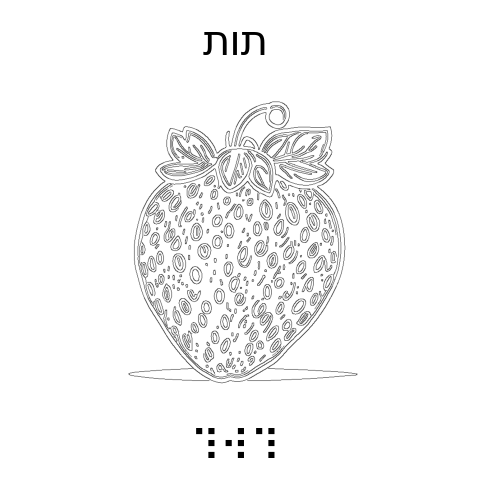

In [118]:
#image processing
image = np.array(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
kernel = np.ones((1, 1), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
edges = cv2.bitwise_not(edges)
h, w = edges.shape
edges[h-1:h, w-1:w] = 255


#centering object
h, w = edges.shape
ys, xs = np.where(edges[1:h-1,1:w-1] == 0)
obj_cx = xs.mean()
obj_cy = ys.mean()
img_cx = w / 2
img_cy = h / 2
shift_x = int(img_cx - obj_cx)
shift_y = int(img_cy - obj_cy)
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
centered = cv2.warpAffine(edges, M, (w, h), borderValue=255)

#plotting final result
plt.figure(figsize=(6,6))
plt.text(500, 100, f'{hebrew_prompt[::-1]}', fontsize=30, color='black', ha='center') #English text
plt.text(500, 1000, f'{Braille}', fontsize=30, color='black', ha='center') #Braille text
plt.imshow(centered, cmap="gray")
plt.axis("off")
plt.show()


In [120]:
# Saving as dxfd
filename = "output.png"
cv2.imwrite(filename, centered)
img_to_dxf(filename)